### Weighted Logistic Regression

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path
import pandas as pd

# Ensure you have created a "data" folder in your project directory 
# and downloaded the CSV file inside it.
file_path = Path.cwd().parent / "data" / "athens_weather_df_2019_2023.csv"

# Load dataset with index and date parsing
lagged_1h_df = pd.read_csv(file_path, parse_dates=["date"])

In [3]:
import pickle

# Load the list of variables to transform
variables_to_transform_path = "../data/variables_to_transform.pkl"

with open(variables_to_transform_path, "rb") as f:
    variables_to_transform = pickle.load(f)

print(variables_to_transform)

['direct_radiation_lag_1h', 'cloud_cover_mid_lag_1h', 'cloud_cover_low_lag_1h', 'vapour_pressure_deficit_lag_1h', 'evapotranspiration_lag_1h']


The issue of severe class imbalance in the target variable was evident during the EDA process and became even more pronounced when we fitted the Standard Logistic Regression model to the data. The unbalanced classes in the target variable significantly impacted the model’s ability to predict minority class instances effectively.

To address this, we will fit a Logistic Regression model that attempts to balance the classes of the target variable. 

This iteration handles class imbalance by automatically adjusting the model to account for the uneven distribution of classes. (this is done by setting the argument `class_weight='balanced'`).   
In this *balanced mode*, the model automatically adjusts the weights of each class inversely proportional to their frequencies in the training data. This adjustment ensures that the minority classes receive more importance during training, without modifying the dataset itself.   

By implementing this weighting strategy, the model is expected to improve its ability to predict **underrepresented classes**, potentially leading to better recall and precision for these categories and finally better overall performance.

- separate the dataset into input space X (the predictor variables) and output space y (the target/response) variable

In [4]:
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

- data is split into a training set (70%) and a test set (30%) using stratified sampling to maintain the proportions of the target variable y in both sets. This ensures that the model is trained and evaluated with the same label distribution. The random state is set for reproducibility.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

- Building and Fitting the Pipeline

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough')  # Leave other features untouched

# Define the pipeline
weighted_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('weighted_model', LogisticRegression(
        class_weight='balanced',
        max_iter=1500,
        random_state=42,
        solver='lbfgs',
        n_jobs=-1
    ))
])


import time
start = time.time()

# Step 3: Fit the pipeline to the training data
weighted_pipeline.fit(X_train, y_train)

# Execution time and number of iterations for the solver to converge
execution_time = time.time() - start
print(f"Execution time: {execution_time:.2f} seconds")
weighted_model_fitted = weighted_pipeline['weighted_model']
print(f"Number of iterations for convergence: {weighted_model_fitted.n_iter_}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['direct_radiation_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h',
                                                   'evapotranspiration_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('weighted_model',
                 LogisticRegression(class_weight='balanced', max_iter=1500,
                                    n_jobs=-1, random_state=42))])

Execution time: 2.04 seconds
Number of iterations for convergence: [162]


- extracting the predicted values of y by passing the test set features (X_test) into the trained model

In [7]:
y_pred_weighted = weighted_pipeline.predict(X_test)

#### **Model Evaluation**

##### **CV evaluation**

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
logreg_weighted_cv = cross_val_score(weighted_pipeline, X_train, y_train, cv=stkf, scoring='balanced_accuracy', n_jobs=-1)
print(logreg_weighted_cv)
print(f'\nThe mean value of balanced_accuracy on the cv evaluation is {logreg_weighted_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy on the cv evaluation is {logreg_weighted_cv.std().round(3)}')

[0.83077652 0.91908443 0.92224647 0.91894939 0.9160378  0.9158996
 0.9155238  0.91695903 0.91374191 0.90727383]

The mean value of balanced_accuracy on the cv evaluation is 0.908

The standard deviation of balanced_accuracy on the cv evaluation is 0.026


##### **The Confusion Matrix**

- Generating the confusion matrix to visualize the performance of the model on the test set this time. The confusion matrix shows how well the model predicted each class by displaying the true positive, false positive, true negative, and false negative counts for each class ('No Precipitation', 'Rain', 'Snowfall').

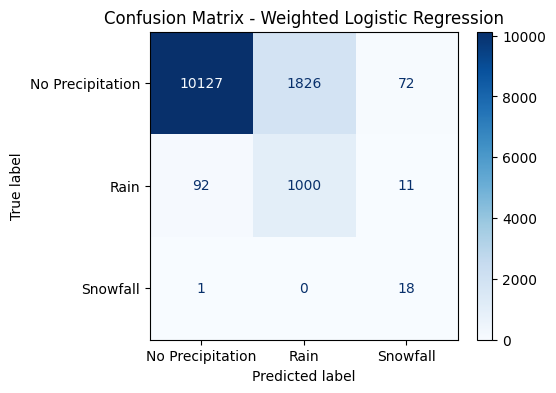

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_weighted, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - Weighted Logistic Regression')
plt.show()

Handling class imbalance, led to significantly better results for the minority classes where the model correctly captured 1000 'Rain' events out of a total of 1103 instances, and also captured 18 out of 19 'Snowfall' events. Additionally, misclassifications of 'Rain' as 'No Precipitation' or 'Snowfall' decreased substantially. For example, the model incorrectly predicted 'No Precipitation' instead of 'Rain' only 92 times, compared to 616 times in the unweighted standard approach.

However, this improvement in recall for the minority classes came at the cost of precision for the majority class ('No Precipitation'). The true positives for 'No Precipitation' dropped from 11,812 to 10127, and the number of actual 'No Precipitation' instances misclassified as 'Rain' increased significantly—from 213 misclassifications in the standard model to 1826 in the weighted approach!

This also demonstrates the precision-recall trade-off mentioned earlier: by focusing on improving recall for the minority classes, the model sacrifices precision, particularly for the majority class.

##### **Model Probabilities and Misclassification: The Snowfall False Negative instance**

Upon examining the confusion matrix, we identified one particular case where an actual snowfall event was misclassified as "no precipitation" by the model. Given the rarity (only 19 instances) of snowfall events in our dataset, we can conduct a deeper analysis to understand the model's decision-making process in this instance.

What has happened in the one actual 'snowfall' instance that was <u>not correctly</u> predicted by the model and was classified as a 'no precipitation' event?

- Extracting Model's Predicted Probabilities

Extracting the predicted probabilities for:
- All correctly classified snowfall events (18 True Positives)
- The single snowfall event that was misclassified as "no precipitation" (1 False Negative)

In [11]:
correctly_predicted_snowfall_events = (y_pred_weighted==2) & (y_test==2)
len(X_test[correctly_predicted_snowfall_events])

18

In [13]:
import numpy as np
np.round(weighted_pipeline.predict_proba(X_test[correctly_predicted_snowfall_events]), 3)

array([[0.   , 0.035, 0.964],
       [0.001, 0.002, 0.997],
       [0.001, 0.001, 0.998],
       [0.001, 0.001, 0.998],
       [0.   , 0.001, 0.999],
       [0.007, 0.181, 0.812],
       [0.   , 0.   , 0.999],
       [0.   , 0.   , 1.   ],
       [0.   , 0.004, 0.996],
       [0.016, 0.408, 0.576],
       [0.001, 0.002, 0.997],
       [0.019, 0.005, 0.976],
       [0.003, 0.102, 0.895],
       [0.001, 0.003, 0.996],
       [0.   , 0.005, 0.995],
       [0.001, 0.008, 0.991],
       [0.009, 0.009, 0.982],
       [0.   , 0.001, 0.999]])

In [14]:
misclassified_snowfall = (y_pred_weighted==0) & (y_test==2)
len(X_test[misclassified_snowfall])

1

In [15]:
np.round(weighted_pipeline.predict_proba(X_test[misclassified_snowfall]), 3)

array([[0.475, 0.063, 0.463]])

From the above results we observe that in all 18 correctly predicted snowfall events (TPs for class 2) the model was highly confident with probabilites in most cases above 99%!   
Only in one instance the probability was lower at 0.575, where the probability of rain was at 0.409 and for no precipitation almost 0.

Regarding the one misclassified actual 'snowfall' event, the model predicted class 2 with 0.457 probability, for 'rain' the probability was 0.06 and finaly the event was classified as 'no precipitation' since it had (even slightly) the highest probability at 0.48.   
It is clear that a manual modification of the probability thresholds of each class is impossimble and would result in a model collapse, destabilizing the model's overall predictive performance

One last action we will perform is extracting and avaraging the average values for the data points corresponding to the 18 TPs of class 2 and compare it with the corresponding data values of the misclassified snowfall event (1 FN).

In [16]:
FN_df = X_test[misclassified_snowfall].round(3)
TP_mean_df = pd.DataFrame(X_test[correctly_predicted_snowfall_events].mean().round(3)).T
result = pd.concat([FN_df, TP_mean_df], axis=0)
result

,month_sin,month_cos,temperature_2m_lag_1h,relative_humidity_2m_lag_1h,dew_point_2m_lag_1h,surface_pressure_lag_1h,cloud_cover_low_lag_1h,cloud_cover_mid_lag_1h,evapotranspiration_lag_1h,vapour_pressure_deficit_lag_1h,wind_speed_10m_lag_1h,wind_gusts_10m_lag_1h,soil_temp_0_to_7cm_lag_1h,soil_moist_0_to_7cm_lag_1h,direct_radiation_lag_1h
18642,0.866,0.500,2.462,67.042,-3.038,1010.523,30.000,2.000,0.052,0.241,26.201,51.48,6.162,0.369,22.000
0,0.703,0.622,2.401,74.890,-1.666,1006.769,70.611,87.389,0.057,0.184,19.370,38.90,4.762,0.350,25.167


In both cases (18 TPs and 1 FN), all variables’ values appear close enough with the exception of `cloud clover low` and `cloud cover mid`, but with **zero** domain knowledge it is impossible to infer if this particular instance is a *data anomaly* and continue investigating further.   

Another potential explanation could be the data recording methodology used by Open-Meteo for the weather parameters incorporated in the model.   
According to Open-Meteo documentation while most of the meteorological variables are reported as instantaneous values at the recorded hour, others—such as precipitation—are aggregated as an average or sum over the preceding hour.

For `cloud_cover_low` and `cloud_cover_mid`, however, the values are recorded instantaneously. This means that while the reported cloud coverage at the given hour was low, it is possible that cloud cover increased significantly during the hour leading up to the snowfall event, and the instantaneous cloud cover values recorded at the given hour might not fully capture the conditions that led to the snowfall. This could explain why the model misclassified the event.

It is important to note that this remains a hypothesis and, without domain expertise in meteorology, further validation is not possible.   

Nonetheless, such considerations lie outside the scope of this practice project.

- save the confusion matrix

In [17]:
from joblib import dump

# Define the file path
conf_matrix_path = "../reports/04_weighted_logistic_regression_confusion_matrix.joblib"

# Save the confusion matrix
dump(conf_matrix_weighted, conf_matrix_path)

print(f"Weighted Logistic Regression confusion matrix saved at: {conf_matrix_path}")

['../reports/04_weighted_logistic_regression_confusion_matrix.joblib']

Weighted Logistic Regression confusion matrix saved at: ../reports/04_weighted_logistic_regression_confusion_matrix.joblib


##### **The Precision-Recall Curve**

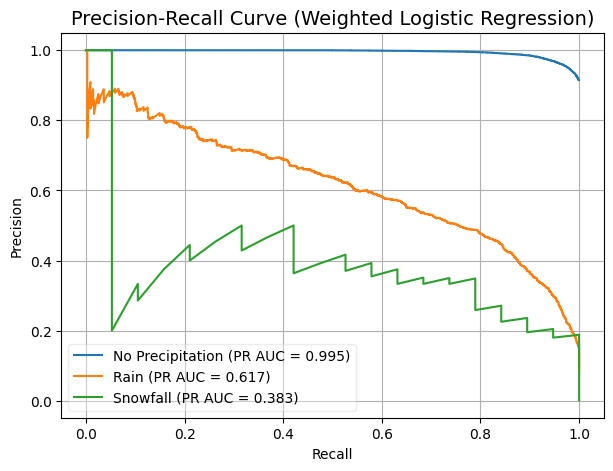

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Predicted probabilities
y_pred_probs_weighted = weighted_pipeline.predict_proba(X_test)

# Define class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Plot Precision-Recall curves
figure = plt.figure(figsize=(7, 5))  # Slightly larger figure for clarity
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_weighted[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve
    curve_plot = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

# Add labels, title, and legend
xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title =plt.title('Precision-Recall Curve (Weighted Logistic Regression)', fontsize=14)
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

##### **The Classification Report**

In [19]:
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)
report_dict_weighted = classification_report(y_test, y_pred_weighted, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_weighted[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_weighted[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_weighted[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_weighted = pd.DataFrame({
    'precision_0': [report_dict_weighted['0']['precision']],
    'recall_0': [report_dict_weighted['0']['recall']],
    'f1_0': [report_dict_weighted['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_weighted['1']['precision']],
    'recall_rain': [report_dict_weighted['1']['recall']],
    'f1_rain': [report_dict_weighted['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_weighted['2']['precision']],
    'recall_snow': [report_dict_weighted['2']['recall']],
    'f1_snow': [report_dict_weighted['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_weighted)],
    'f1_macro': [f1_score(y_test, y_pred_weighted, average='macro')],
    'pr_auc_macro': [average_precision_score(y_test, y_pred_probs_weighted, average='macro')]
})

print('Weighted Logistic Regression')
report_df_weighted = report_df_weighted.round(4)
report_df_weighted

Weighted Logistic Regression


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_macro,pr_auc_macro
0,0.9909,0.8422,0.9105,0.9947,0.3539,0.9066,0.509,0.6167,0.1782,0.9474,0.3,0.3829,0.8987,0.5732,0.6706


- save the metrics report

In [20]:
# Define the file path
report_path = "../reports/04_weighted_logistic_regression_report.joblib"

# Save the report DataFrame
dump(report_df_weighted, report_path)

print(f"Weighted Logistic Regression report saved at: {report_path}")

['../reports/04_weighted_logistic_regression_report.joblib']

Weighted Logistic Regression report saved at: ../reports/04_weighted_logistic_regression_report.joblib


##### **The learning curve**

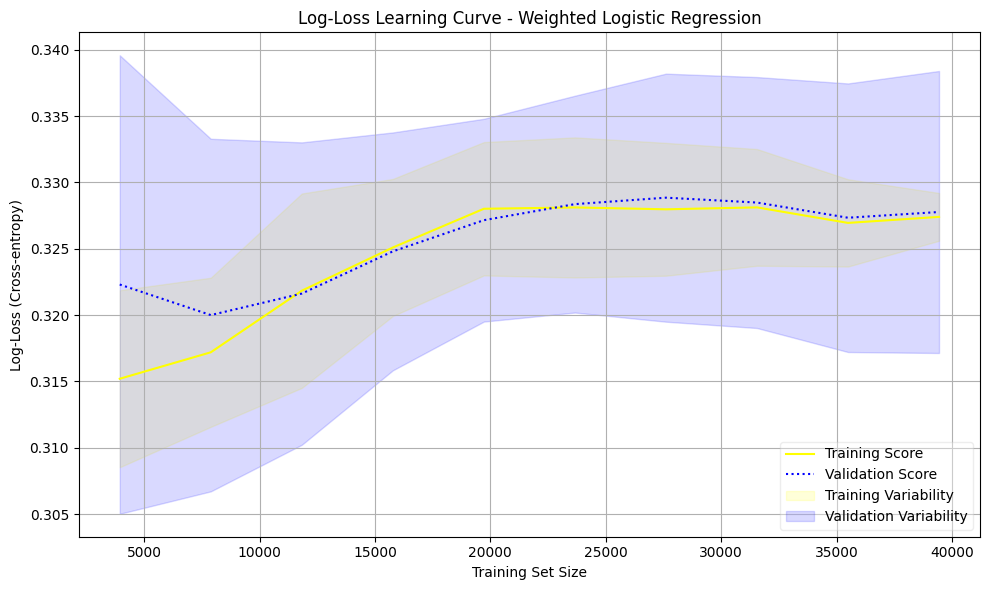

In [21]:
import numpy as np
from sklearn.model_selection import learning_curve
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    weighted_pipeline, X, y, cv=stkf, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Log-Loss (Cross-entropy)')
title = plt.title('Log-Loss Learning Curve - Weighted Logistic Regression')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

Compared to the standard (unweighted) model, log-loss increased significantly, which was expected. This reflects the trade-off introduced by balancing the target classes, which led to a higher number of misclassified instances overall.   

The learning curve for the weighted logistic regression model shows that the log-loss for both training and validation sets closely aligns, converging at ~0.328 when the full dataset is used. This suggests no signs of overfitting.   

As the full dataset is fed into the model both lines appear to plateau suggesting that further improvements from additional data are unlikely.   

Finally, the observed variance in validation prediction errors remains significant, indicating that the model struggles to generalize well on unseen data.

**Save the Trained Model**

In [22]:
# Define the file path
model_path = "../models/weighted_logistic_regression.joblib"

# Save the entire pipeline
dump(weighted_pipeline, model_path)

print(f"Weighted Logistic Regression model saved at: {model_path}")

['../models/weighted_logistic_regression.joblib']

Weighted Logistic Regression model saved at: ../models/weighted_logistic_regression.joblib
